In [1]:
%pylab inline
import cvxpy as cvx

Populating the interactive namespace from numpy and matplotlib


#### Helper functions 

In [2]:
def simulate_trajectories(sampled_returns, b):
    """Simulate log-wealth trajectories."""
    N_SAMPLES, T, n = sampled_returns.shape
    return np.hstack([np.zeros((N_SAMPLES, 1)),
                      np.cumsum(log(np.dot(sampled_returns, b)), axis=1)])

def growth_rate_Wmins(logw_samples):
    """Simulate expected log growth rate and samples W_min."""
    T = logw_samples.shape[1] - 1
    return mean(logw_samples[:,-1])/T, exp(np.min(logw_samples, axis=1))

def drawdown_prob(W_mins, alpha):
    return sum(W_mins < alpha)/float(len(W_mins))

def empirical_cdf(samples, grid):
    return array([sum(samples <= el) for el in grid], dtype=float) / len(samples)

# Definitions 

### Constants 

In [3]:
n = 20 # number of assets, including risk-free
K = 100 # number of scenarios

# generate returns
np.random.seed(0)
pi = np.random.uniform(size = K) 
pi /= sum(pi)
min_return = .7
max_return = 1.3
r = np.random.uniform(low = min_return, high = max_return, size=(n,K))
for i in range(30):
    r[np.random.choice(range(n)),np.random.choice(range(K))] = 0.1
    r[np.random.choice(range(n)),np.random.choice(range(K))] = 2.5
r[-1,:] = 1.0

# Monte Carlo sample
MC_N_SAMPLES = 10000
MC_T = 100
np.random.seed(0)
mc_sample = r[:, np.random.choice(r.shape[1], size = MC_N_SAMPLES * MC_T, p = pi)]

# risk-constrained
alpha = 0.7
beta = 0.1

### Define RCK

In [4]:
b_rck = cvx.Variable(n)
lambda_rck = cvx.Parameter(sign='positive')
growth_rate = pi.T*cvx.log(r.T*b_rck)
risk_constraint = cvx.log_sum_exp(log(pi) - lambda_rck*cvx.log(r.T*b_rck)) <= 0
constraints = [cvx.sum_entries(b_rck) == 1, b_rck >= 0, risk_constraint] 
probl_rck = cvx.Problem(cvx.Maximize(growth_rate), constraints)

### Define QRCK

In [5]:
mu = sum(r * pi, 1) - 1
rhos = matrix(r-1)
second_moment = np.zeros((n,n))
for i in range(K):
    second_moment += pi[i] * rhos[:,i] * rhos[:,i].T
    
b_qrck = cvx.Variable(n)
lambda_qrck = cvx.Parameter(sign='positive')
growth = b_qrck.T*mu
variance = cvx.quad_form(b_qrck, second_moment)
risk_constraint_qrck = lambda_qrck*(lambda_qrck + 1) * variance/2. <= lambda_qrck*growth
constraints = [cvx.sum_entries(b_qrck) == 1, b_qrck >= 0, risk_constraint_qrck] 
probl_qrck = cvx.Problem(cvx.Maximize(growth - variance/2.), constraints)

# Comparison of Kelly and RCK bets 

### Table RCK

In [6]:
print "lambd\tgr_MC\tprob_th\tprob_MC"
for lambda_rck.value in [0, log(beta)/log(alpha), 5.5]:
    print '%.3f '% lambda_rck.value,
    probl_rck.solve()
    exp_growth_rate, W_mins = growth_rate_Wmins(
        simulate_trajectories(np.reshape(mc_sample.T, (MC_N_SAMPLES, MC_T, n)), 
                              b_rck.value.A1))
    print '& %.3f '% (exp_growth_rate),
    print '& %.3f '% (exp(lambda_rck.value * log(alpha))),
    print '& %.3f \\\\'% drawdown_prob(W_mins, alpha)

lambd	gr_MC	prob_th	prob_MC
0.000  & 0.062  & 1.000  & 0.398 \\
6.456  & 0.043  & 0.100  & 0.073 \\
5.500  & 0.047  & 0.141  & 0.099 \\


### Wealth trajectories

trajectories with W_min < alpha: 4 of 10
trajectories with W_min < alpha: 1 of 10


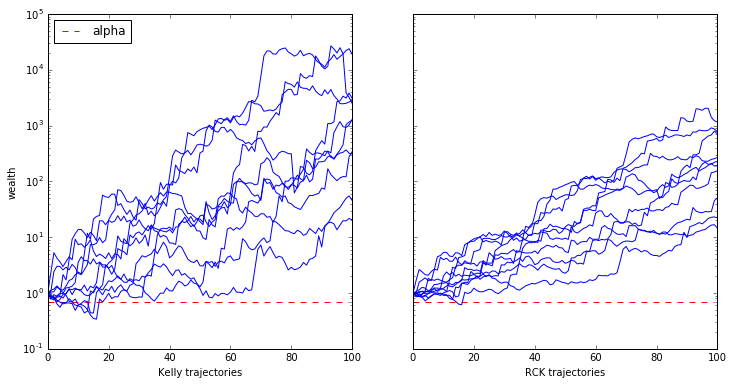

In [10]:
N_TRAJ = 10
OFFSET = 2
lambda_star = 5.5

figure(figsize(12,6))
f, (ax1, ax2) = subplots(1, 2, sharey=True)
ax1.semilogy(arange(MC_T), [alpha]*MC_T, 'r--', label = 'alpha')
ax2.semilogy(arange(MC_T), [alpha]*MC_T, 'r--', label = 'alpha')
ax1.set_xlabel("Kelly trajectories")
ax2.set_xlabel("RCK trajectories")
ax1.set_ylabel("wealth")
ax1.legend(loc='upper left')

for ax, lambda_rck.value in zip([ax1, ax2], [0., lambda_star]):
    probl_rck.solve()
    logw_samples = simulate_trajectories(np.reshape(mc_sample[:, OFFSET:OFFSET+N_TRAJ*MC_T].T, 
                                                    (N_TRAJ, MC_T, n)), 
                                         b_rck.value.A1)
    print "trajectories with W_min < alpha: %d of %d" %\
        (sum(exp(np.min(logw_samples, axis=1)) < alpha), N_TRAJ)
    for i in range(N_TRAJ): 
        wealth = exp(logw_samples[i,:])
        ax.semilogy(wealth, 'b') 
        
_ = savefig('wealth_trajectories_finite.png')

### Sample CDF of Wmin 

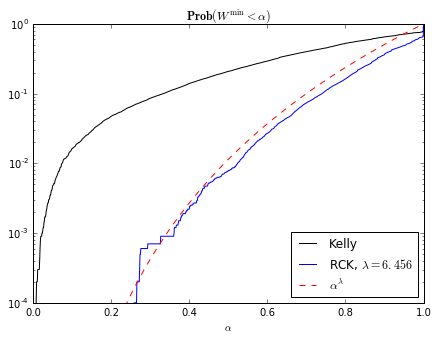

In [11]:
W_min_samples = []

for lambda_rck.value in [0, log(beta)/log(alpha)]:
    probl_rck.solve()
    exp_growth_rate, W_mins = growth_rate_Wmins(
        simulate_trajectories(np.reshape(mc_sample.T, (MC_N_SAMPLES, MC_T, n)), 
                              b_rck.value.A1))
    W_min_samples.append(W_mins)

step = 0.001
x = np.arange(0,1+step,step)

figure(figsize=(7,5))
semilogy(x, empirical_cdf(W_min_samples[0], x), 'k', label='Kelly')
semilogy(x, empirical_cdf(W_min_samples[1], x), 'b', 
         label='RCK, $\lambda = %.3f$'%(log(beta)/log(alpha)))

_ = ylim()
semilogy(x, x**(log(beta)/log(alpha)), 'r--',label = '$\\alpha^\lambda$')
ylim(_)
title('$\mathbf{Prob}(W^{\mathrm{min}} < \\alpha )$')
xlabel('$\\alpha$')
legend(loc='lower right')
savefig('sample_cdf_wmin_finite.png')

# Comparison of risk bound and Monte Carlo risk 

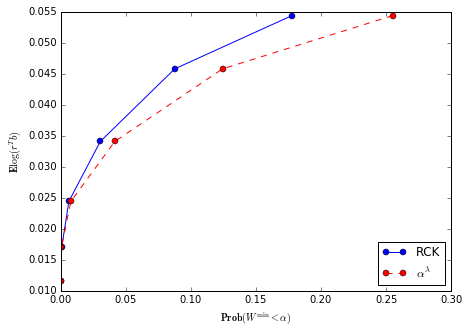

In [12]:
optvals = []
exp_growth_rates = []
W_min_samples = []

lambda_risks = np.logspace(.4,1.5,7)

for lambda_rck.value in lambda_risks:
    optvals.append(probl_rck.solve())
    exp_growth_rate, W_mins = growth_rate_Wmins(
        simulate_trajectories(np.reshape(mc_sample.T, (MC_N_SAMPLES, MC_T, n)), 
                              b_rck.value.A1))
    exp_growth_rates.append(exp_growth_rate)
    W_min_samples.append(W_mins)
    
figure(figsize=(7,5))
plot(array([drawdown_prob(el, alpha) for el in W_min_samples])[1:], 
     array(optvals)[1:], 'b-o', label='RCK')
plot((alpha**lambda_risks)[1:], 
     array(optvals)[1:], 'r--o', label='$\\alpha^\\lambda$')
legend(loc='lower right')
xlabel('$\mathbf{Prob}(W^{\mathrm{min}} < \\alpha )$')
ylabel('$\mathbf{E} \log (r^Tb)$')
savefig('risk_bound_vs_MC_finite.png')

# Comparison of RCK and QRCK

### Table QRCK 

In [22]:
print "lambd\tgr_MC\tprob_th\tprob_MC"
for lambda_qrck.value in [0, log(beta)/log(alpha), 2.8]:
    print '%.3f'% lambda_qrck.value,
    probl_qrck.solve()
    exp_growth_rate, W_mins = growth_rate_Wmins(
        simulate_trajectories(np.reshape(mc_sample.T, (MC_N_SAMPLES, MC_T, n)), b_qrck.value.A1))
    print '& %.3f '% (exp_growth_rate),
    print '& %.3f '% (exp(lambda_qrck.value * log(alpha))),
    print '& %.3f \\\\'% drawdown_prob(W_mins, alpha)

lambd	gr_MC	prob_th	prob_MC
0.000 & 0.054  & 1.000  & 0.218 \\
6.456 & 0.027  & 0.100  & 0.025 \\
2.800 & 0.044  & 0.368  & 0.100 \\


### Comparison of the values of $b_i$ 

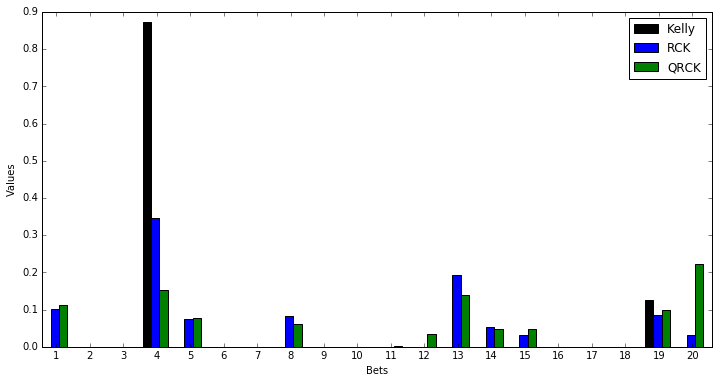

In [14]:
lambda_rck.value = 0.
probl_rck.solve()
result_b_kelly = b_rck.value.A1

lambda_rck.value = log(beta)/log(alpha)
probl_rck.solve()
result_b_rck = b_rck.value.A1

lambda_qrck.value = log(beta)/log(alpha)
probl_qrck.solve()
result_b_qrck = b_qrck.value.A1

ind = np.arange(n)  # the x locations for the groups
width = 0.25       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, result_b_kelly, width, color='k')
rects2 = ax.bar(ind + width, result_b_rck, width, color='b')
rects3 = ax.bar(ind + 2*width, result_b_qrck, width, color='g')

ax.set_ylabel('Values')
ax.set_xlabel('Bets')
ax.set_xticks(ind + width*1.6666)
ax.set_xticklabels(['%d'%i for i in range (1,21)])
ax.legend((rects1[0], rects2[0], rects3[0]), ('Kelly', 'RCK', 'QRCK'))

plt.savefig("values_bets_comparison_finite.png")

# Risk-growth trade-off of RCK, QRCK, and fractional Kelly bets

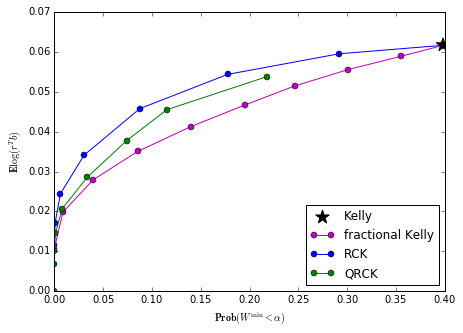

In [16]:
# obtain fractional bets
num_frac_bets = 11
risk_free_bet = array([0.]*(n-1) + [1.])
fractional_bets = [f * result_b_kelly + (1-f) * risk_free_bet
                  for f in np.linspace(0, 1, num = num_frac_bets, endpoint=True)]

result_MC_frac = [growth_rate_Wmins(
        simulate_trajectories(np.reshape(mc_sample.T, (MC_N_SAMPLES, MC_T, n)), b_frac)) 
    for b_frac in fractional_bets]

# RCK and QRCK
lambda_risks = np.concatenate([[0.], np.logspace(.4,1.5,7)])

result_MC_RCK = []
for lambda_rck.value in lambda_risks:
    probl_rck.solve()
    result_MC_RCK.append(growth_rate_Wmins(
        simulate_trajectories(np.reshape(mc_sample.T, (MC_N_SAMPLES, MC_T, n)), 
                              b_rck.value.A1)))
result_MC_QRCK = []
for lambda_qrck.value in lambda_risks:
    probl_qrck.solve()
    result_MC_QRCK.append(growth_rate_Wmins(
        simulate_trajectories(np.reshape(mc_sample.T, (MC_N_SAMPLES, MC_T, n)), 
                              b_qrck.value.A1)))
    
figure(figsize=(7,5))

l1 = plot(array([drawdown_prob(el[1], alpha) for el in result_MC_RCK]), 
      [el[0] for el in result_MC_RCK], 'b-o', label='RCK', zorder=1)
l2 = plot(array([drawdown_prob(el[1], alpha) for el in result_MC_frac]), 
      [el[0] for el in result_MC_frac], 'm-o', label='fractional Kelly', zorder=1)
l3 = plot(array([drawdown_prob(el[1], alpha) for el in result_MC_QRCK]), 
      [el[0] for el in result_MC_QRCK], 'g-o', label='QRCK', zorder=1)
xl = xlim()
yl = ylim()
s1 = scatter(drawdown_prob(result_MC_RCK[0][1], alpha),
     result_MC_RCK[0][0], color='k', marker='*', s=200, label='Kelly', zorder=2)
lines = [s1, l2[0], l1[0], l3[0]]
legend(lines, [el.get_label() for el in lines], loc='lower right',  scatterpoints=1)
xlabel('$\mathbf{Prob}(W^{\mathrm{min}} < \\alpha )$')
ylabel('$\mathbf{E} \log (r^Tb)$')
xl = xlim(xl)
yl = ylim(yl)
savefig('risk_growth_trade_off_finite.png')